#Introduction to Deep Learning 2023-2
## Cardiac Arrhythmia challenge

Autores:
- 2190435J uan Sebastian Guerrero Peña
- 2190433 Rafael Santiago Suarez Gil


# Resumen

En este cuaderno se llevaron a cabo las distintas pruebas y modelos, los mismos se encuentran en la seccion [Sandbox](#scrollTo=Tytut8-KYgEe).
El modelo definitov se encuentra en la seccion [model](#scrollTo=FHTCOQflx0Wp)
- Kfold: Donde se aplico validacion cruzada para mostrar la validez de la arquitectura
- No Kfold: La version desplegada y donde se enviaron los resultados, esta usa el 80% de los datos para entrenarse.

El modelo keras esta disponible en es [link](https://drive.google.com/file/d/1DHFXWbuIzwr4dLW_SoMtqhWleBaizDsi/view?usp=sharing).

## Arquitectura:
n_samples es el numero de muestra que se quieran evaluar

Input: (n_samples, 2049)

Output: (n_samples, 3)
[![Arquitectura-full.png](https://i.postimg.cc/vmfmw5PP/Arquitectura-full.png)](https://postimg.cc/rdyTSR2W)

## Resultados
### Kfold
Para los test en kfold, se tienen los siguientes [resultados](#scrollTo=-PYBKXtsi9QG):

| Métrica   | Media  | Desv. Estándar |
|-----------|--------|----------------|
| Precisión | 0.8953 | ±0.00876       |
| Recall    | 0.8731 | ±0.03617       |
| F1-Score  | 0.8819 | ±0.02362       |

### No kfold
Para datos de muestra separados previamente de los de entrenamiento el modelo *no kfold* produce la siguiente [matriz de confusion](#scrollTo=QNRTD47FRUl1):

[![matriz-confusion.png](https://i.postimg.cc/2S442LQD/matriz-confusion.png)](https://postimg.cc/Wd1F43YW)

# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#data libraries
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

#model libraries
import os
import torch
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support




# Extracting the Training Data
The training data is saved in the file 'training_set_500.h5', which is in [h5
format](https://fileinfo.com/extension/h5).  This format allows to save Hierarchical Data.  In this file we have saved the 'data' and the 'labels'

We extract the 'data' and the 'labels' to the variables X_train and y_train respectively and then convert these variable into numpy arrays.

**The dataset has 3 labels :**

*   0: Normal
*   1: Arrhythmia
*   2: Noise




In [ ]:
dict_class = {0: 'Normal',1: 'Arrhythmia',2: 'Noise'}
# PATH TO THIS FOLDER IN DRIVE

try:
  data_path = "/content/gdrive/MyDrive/Deep_learning/Deep_Project"#Rafael Path
  # Traing Data - ECG signals from 500 patients
  #dataset = h5py.File(data_path + '/training_set_500.h5', 'r')
  with h5py.File(data_path + '/Split_data/set_500_c.h5', 'r') as dataset:
    # Obtén los conjuntos de datos
    X_train = np.array(dataset.get('data_train'))
    y_train = np.array(dataset.get('labels_train'))
    X_test = np.array(dataset.get('data_test'))
    y_test = np.array(dataset.get('labels_test'))
    X_val = np.array(dataset.get('data_val'))
    y_val = np.array(dataset.get('labels_val'))
except:
  data_path = "/content/gdrive/Othercomputers/Mi PC/Decimo Semestre/DeepLearning/Deep_Project" #Sebastian Path
  # Traing Data - ECG signals from 500 patients
  #dataset = h5py.File(data_path + '/training_set_500.h5', 'r')
  with h5py.File(data_path + '/Split_data/set_500_c.h5', 'r') as dataset:
      # Obtén los conjuntos de datos
      X_train = np.array(dataset.get('data_train'))
      y_train = np.array(dataset.get('labels_train'))
      X_test = np.array(dataset.get('data_test'))
      y_test = np.array(dataset.get('labels_test'))
      X_val = np.array(dataset.get('data_val'))
      y_val = np.array(dataset.get('labels_val'))

# Healthy assertion
#assert X_train.shape == (116953, 2049, 1)  # The training data has 116953 1D ECG signals each one with 2049 samples
#assert y_train.shape == (116953, 1) # 116953 labels (0: Normal, 1: Cardiac Arrhytmia, 2: Noise signal)

## Converting the y_train to one-hot encoding

In [ ]:
nclases = 3
y_train = to_categorical(y_train,nclases)
y_test = to_categorical(y_test,nclases)
y_val = to_categorical(y_val,nclases)

print("y_train= ", y_train[0])
# Healthy assertion
#assert y_train.shape == (116953, 3) # 116953 labels ([1. 0. 0.]: Normal, [0. 1. 0.]: Cardiac Arrhytmia, [0. 0. 1.]: Noise signal)

y_train=  [1. 0. 0.]


# Z-Score

In [ ]:
### Z-score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.squeeze(X_train))
X_test = scaler.transform(np.squeeze(X_test))
X_val = scaler.transform(np.squeeze(X_val))

## Sketching some ECG Signal

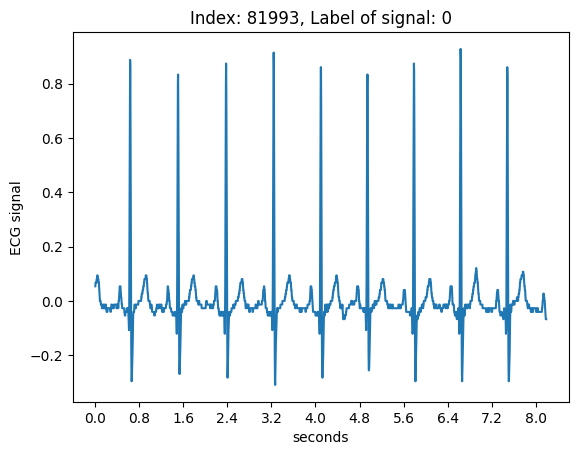

In [ ]:
clase = 0
incorrect = True

while incorrect:
  index = np.random.randint(len(X_train))
  if np.argmax(y_train[index]) == clase:
    incorrect = False



x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_train[index])
plt.title('Index: %i, Label of signal: %i'  % (index, np.argmax(y_train[index])))
plt.xlabel('seconds')
plt.ylabel('ECG signal')

plt.show()

# Extracting the Test Data for submission
The test data is saved in the file '/test_without_labels_200.h5', which is also in [h5
format](https://fileinfo.com/extension/h5).  
We extract the 'data' to the variable X_test. **Please note that the test labels  are hidden for challenge purposes.**

In [ ]:
#Testing Data - ECG signals from 200 patients
dataset = h5py.File(data_path +'/test_without_labels_200.h5', 'r')
X_test_submit = dataset.get('data')
X_test_submit = np.array(X_test_submit)
dataset.close()

# Healthy assertion
assert X_test_submit.shape == (46943, 2049, 1) # 46943 1D ECG signal each one with 2049 samples
X_test_submit = scaler.transform(np.squeeze(X_test_submit))

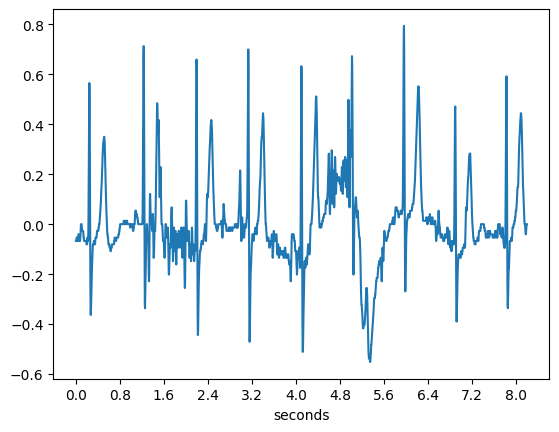

In [ ]:
index = np.random.randint(len(X_test_submit))
x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_test_submit[index])
#plt.title('Index: %i, Label of signal: %i'  % (index, np.argmax(y_train[index])))
plt.xlabel('seconds')
#plt.ylabel('ECG signal')

plt.show()

#Model

In [ ]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=2,restore_best_weights = True,verbose=1)
ReduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3,factor=0.3,restore_best_weights = True,verbose=1)


## K-fold

###### Arquitectura

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)  # Assuming ECG data with 256 samples

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(8):
        subsample = (i % 2 == 1) # cada 2 bloques hace un subsample
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample) # Cada 4 duplica la cantidad de filtros
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

# Display model summary
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2049, 1)]            0         []                            
                                                                                                  
 conv1d_27 (Conv1D)          (None, 2049, 16)             272       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_20 (Ba  (None, 2049, 16)             64        ['conv1d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 2049, 16)             0         ['batch_normalization_20

In [ ]:
!pip install plot_model
!pip install graphviz

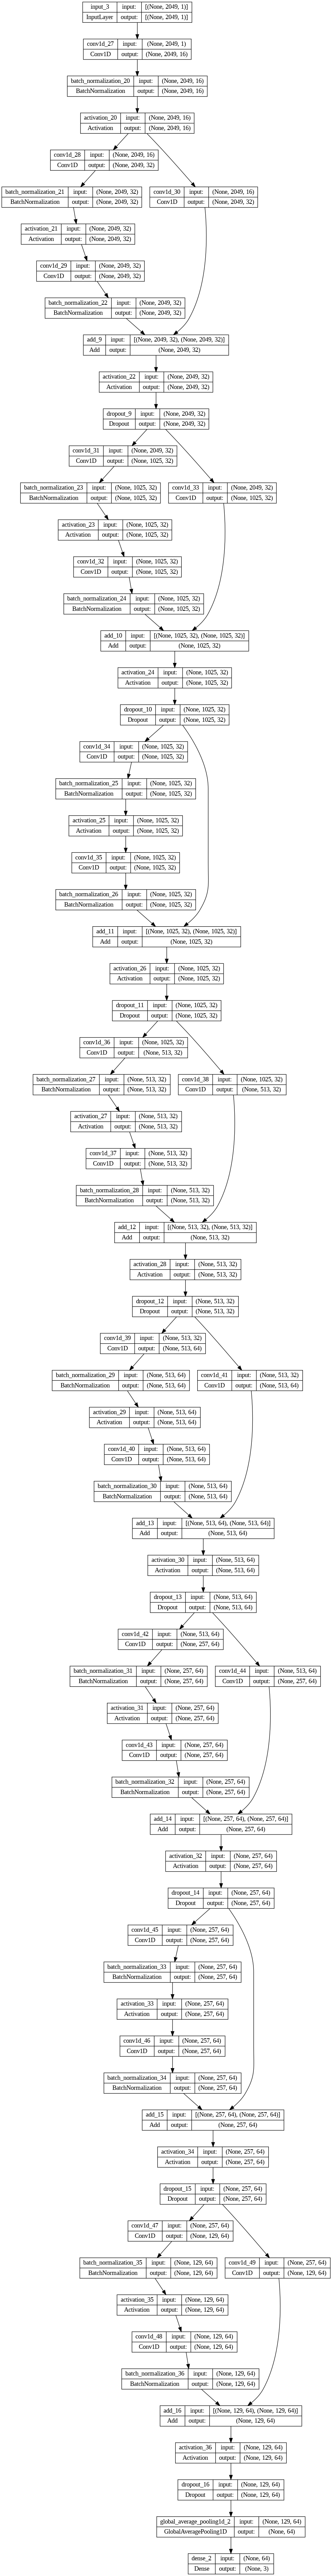

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)

##### Entrenamiento

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
best_model = None
best_val_f1 = 0
folds = list(enumerate(skf.split(X_train, y_train)))
i = 0
list_results = []

In [ ]:
train_index, test_index = folds[i][1]
model = build_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(np.squeeze(X_train[train_index], axis=-1), y_train[train_index], epochs=100, batch_size=32, validation_data=(X_val, y_val) ,callbacks = [EarlyStopping])
#Predicción
#val_loss, val_acc = model.evaluate(X_train[test_index], y_train[test_index], verbose=1)

y_pred = model.predict(X_train[test_index])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_train[test_index]

# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes, average='macro')
list_results.append((precision, recall, f1))

# Imprimir las métricas
print(f"Precision: {precision}, Recall: {recall}, F1-score: {f1}")
if best_model is None or f1 > best_val_f1:
      best_model = model
      best_val_f1 = f1
      best_fold = i
print(f'best fold so far: {best_fold}')
print(f'Complete fold {i}')
i += 1


##### Testeo

In [ ]:
precision_recall_fscore_support(y_true_classes, y_pred_classes)

(array([0.92411247, 0.8649789 , 0.87143656]),
 array([0.90678598, 0.58992806, 0.92262169]),
 array([0.91536724, 0.70145423, 0.89629896]),
 array([9387,  695, 6759]))

In [ ]:
d = np.std(list_results, axis=0)
p = np.mean(list_results, axis=0)
print(f'Precision: {p[0]}({d[0]}) \n Recall:{p[1]}({d[1]}) \n F1-score:{p[2]}({d[2]})')

Precision: 0.8953492025960526(0.00876219418611131) 
 Recall:0.873176471924333(0.036171800001402354) 
 F1-score:0.8819089555978754(0.02362080736391438)


In [ ]:
print(f'Best model: Fold {best_fold}')
best_model.save(data_path + '/models/best_kfold.keras')

Best model: Fold 0


In [ ]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

731/731 [==============================] - 8s 11ms/step


In [ ]:

# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9381507381507381, Recall: 0.9270577395577395, F1-score: 0.9325712520274967, Support: 13024
Clase Arrhythmia - Precision: 0.8704720087815587, Recall: 0.8508583690987125, F1-score: 0.8605534454693435, Support: 932
Clase Noise - Precision: 0.894276795005203, Recall: 0.910863804981452, F1-score: 0.902494092937779, Support: 9435
Matriz de Confusión:
[[12074    28   922]
 [   45   793    94]
 [  751    90  8594]]


In [ ]:
precision_recall_fscore_support(y_true_classes, y_pred_classes,  average='macro')

(0.9144612463809159, 0.9106393142069108, 0.9125356225830469, None)


## NO k-fold

###### Arquitectura

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)  # Assuming ECG data with 256 samples

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(8):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2049, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2049, 16)             272       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2049, 16)             64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2049, 16)             0         ['batch_normalization[0][0

##### Entrenamiento

In [ ]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=4,restore_best_weights = True,verbose=1)
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val) ,callbacks = [EarlyStopping])

Epoch 1/100
2632/2632 [==============================] - 162s 49ms/step - loss: 0.3943 - accuracy: 0.8498 - val_loss: 0.3107 - val_accuracy: 0.8833
Epoch 2/100
2632/2632 [==============================] - 122s 46ms/step - loss: 0.2795 - accuracy: 0.8908 - val_loss: 0.2751 - val_accuracy: 0.8988
Epoch 3/100
2632/2632 [==============================] - 126s 48ms/step - loss: 0.2537 - accuracy: 0.9006 - val_loss: 0.2589 - val_accuracy: 0.9022
Epoch 4/100
2632/2632 [==============================] - 123s 47ms/step - loss: 0.2414 - accuracy: 0.9056 - val_loss: 0.2397 - val_accuracy: 0.9081
Epoch 5/100
2632/2632 [==============================] - 122s 46ms/step - loss: 0.2337 - accuracy: 0.9074 - val_loss: 0.2469 - val_accuracy: 0.9047
Epoch 6/100
2632/2632 [==============================] - 125s 47ms/step - loss: 0.2258 - accuracy: 0.9125 - val_loss: 0.2257 - val_accuracy: 0.9125
Epoch 7/100
2632/2632 [==============================] - 122s 46ms/step - loss: 0.2196 - accuracy: 0.9141 - val_

##### Testeo

In [ ]:
#from tensorflow.keras.models import load_model
#model = load_model(data_path + '/models/generarData_my_model.keras')

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 10s 13ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9312245206099955, Recall: 0.9470976658476659, F1-score: 0.939094023601066, Support: 13024
Clase Arrhythmia - Precision: 0.8445336008024072, Recall: 0.9034334763948498, F1-score: 0.8729911871435978, Support: 932
Clase Noise - Precision: 0.9212942719720157, Recall: 0.8932697403285639, F1-score: 0.9070655975891946, Support: 9435
Matriz de Confusión:
[[12335    14   675]
 [   45   842    45]
 [  866   141  8428]]


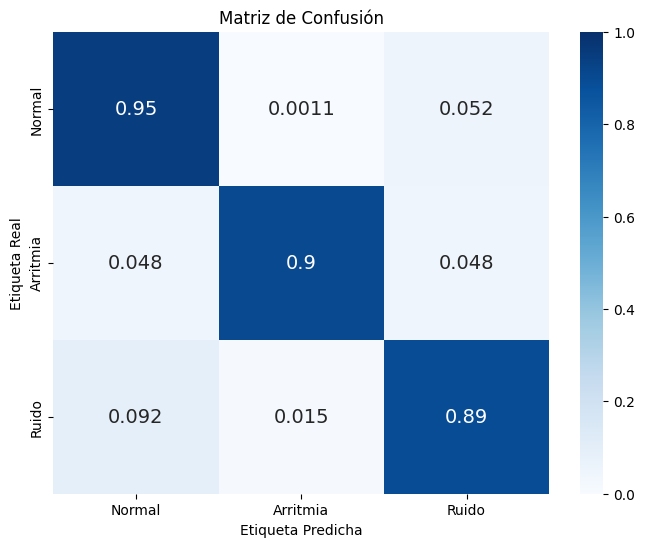

In [ ]:
import seaborn as sns
labels = ["Normal", "Arritmia", "Ruido"]
# Calcular el total de muestras en cada clase real
class_totals = np.sum(conf_matrix, axis=1, keepdims=True)

# Calcular el porcentaje de muestras en cada clase predicha
conf_matrix_percent = conf_matrix / class_totals

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            vmin=0, vmax=1,
            annot_kws={'size': 14})
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')
plt.show()

In [ ]:
precision_recall_fscore_support(y_true_classes, y_pred_classes,  average='macro')

(0.8990174644614729, 0.9146002941903598, 0.9063836027779528, None)

# Calculate the predictions on the X_test, save and submit the results

When you are satisfied with your results:

*   Calculate y_pred, which is the prediction for the X_test
*   Save it on a .npy file
*   Submit your results on the Classroom

I will sent you the accuracy on this file.

In [ ]:
#Agregado
model_path = data_path+'/models/generarData_my_model.keras'
model = keras.models.load_model(model_path)
#####
y_pred = model.predict(X_test_submit)
y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
assert y_pred.shape == (46943,3)

1467/1467 [==============================] - 25s 11ms/step


In [ ]:
#FILE FOR SUBMISSION
#np.save(data_path + '/Carlos_Fajardo_prediction',y_pred)
np.save(data_path + '/Sebastian_and_Rafael_prediction',y_pred)

**Do not edit the code below, it is for testing results**

In [ ]:
# dataset_test = h5py.File(data_path + '/test_with_labels_200.h5', 'r')
# y_test = dataset_test.get('labels')
# y_test = np.array(y_test)
# assert y_test.shape == (46943, 1)

# from sklearn.metrics import accuracy_score
# y_predictions = np.zeros(shape=(y_pred.shape[0], 1))

# for i in range(y_pred.shape[0]):
#   y_predictions[i] = np.asarray(np.where(y_pred[i] == 1))

# test_accuracy = accuracy_score(y_test, y_predictions)
# print(test_accuracy)

# Sandbox

## Data exploration

In [ ]:
# Traing Data - ECG signals from 500 patients
data_path = "/content/gdrive/Othercomputers/Mi PC/Decimo Semestre/DeepLearning/Deep_Project"
dataset = h5py.File(data_path + '/training_set_500.h5', 'r')

#X_train_v = dataset.get('data')
#X_train_v = np.array(X_train_v)
y_train_v = dataset.get('labels')
y_train_v = np.array(y_train_v)
dataset.close()
nclases = 3
y_train_v = to_categorical(y_train_v,nclases)


[[    0 65196]
 [    1  4755]
 [    2 47002]]


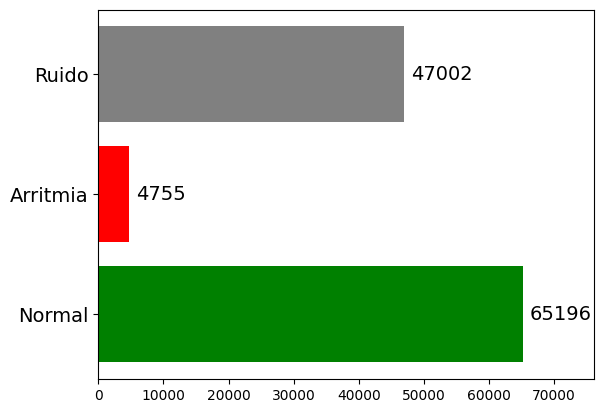

In [ ]:

unique, counts = np.unique(np.argmax(y_train_v,axis=1), return_counts=True)
import matplotlib.pyplot as plt
bin_counts = np.bincount(np.argmax(y_train_v,axis=1))
labels = ['Normal', 'Arritmia', 'Ruido']

for index, value in enumerate(bin_counts):
    plt.text(value+1000, index, str(value), ha='left', va='center', fontsize=14)

plt.tick_params(axis='y', labelsize=14)
plt.barh(labels, bin_counts, align='center',color=['green', 'red', 'gray'])
plt.xlim(0, max(bin_counts) + 11000)
print(np.asarray((unique, counts)).T)

In [ ]:
bin_counts

array([65196,  4755, 47002])

## Synthetic Data

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = 'not majority')
X_train, y_train = sm.fit_resample(np.squeeze(X_train), y_train)

[[    0 41775]
 [    1 41775]
 [    2 41775]]


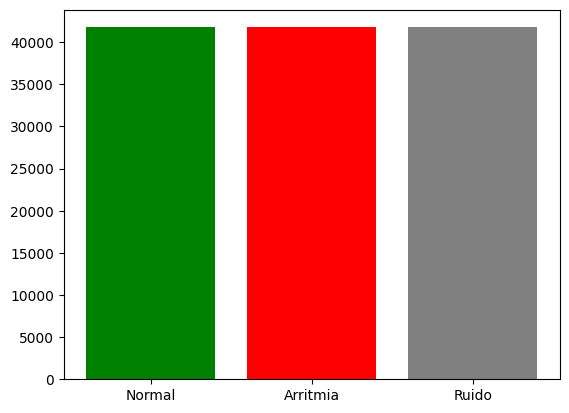

In [ ]:
unique, counts = np.unique(np.argmax(y_train,axis=1), return_counts=True)
import matplotlib.pyplot as plt
bin_counts = np.bincount(np.argmax(y_train,axis=1))
labels = ['Normal', 'Arritmia', 'Ruido']

plt.bar(labels, bin_counts, width=0.8, align='center',color=['green', 'red', 'gray'])
print(np.asarray((unique, counts)).T)

array([ True,  True,  True])

## Models

### Callbacks

In [ ]:
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', patience=4,restore_best_weights = True,verbose=1)
ReduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3,factor=0.3,restore_best_weights = True,verbose=1)

### Arrhythmia Detection and Classification (Hannun et al, 2019)
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6784839/

#### Version 1: Raw

###### Arquitectura

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(data_path + 'my_model.keras')

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)  # Assuming ECG data with 256 samples

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(8):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2049, 1)]            0         []                            
                                                                                                  
 conv1d_68 (Conv1D)          (None, 2049, 16)             272       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_50 (Ba  (None, 2049, 16)             64        ['conv1d_68[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_50 (Activation)  (None, 2049, 16)             0         ['batch_normalization_50

##### Entrenamiento

In [ ]:
model.fit(np.squeeze(X_train, axis=-1), y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val) ,callbacks = [EarlyStopping])

Epoch 1/10
2340/2340 [==============================] - 151s 52ms/step - loss: 0.3703 - accuracy: 0.8571 - val_loss: 0.3044 - val_accuracy: 0.8838
Epoch 2/10
2340/2340 [==============================] - 122s 52ms/step - loss: 0.2732 - accuracy: 0.8941 - val_loss: 0.2696 - val_accuracy: 0.8989
Epoch 3/10
2340/2340 [==============================] - 120s 51ms/step - loss: 0.2558 - accuracy: 0.9007 - val_loss: 0.2512 - val_accuracy: 0.9045
Epoch 4/10
2340/2340 [==============================] - 120s 51ms/step - loss: 0.2420 - accuracy: 0.9066 - val_loss: 0.2857 - val_accuracy: 0.8915
Epoch 5/10
2340/2340 [==============================] - 119s 51ms/step - loss: 0.2330 - accuracy: 0.9097 - val_loss: 0.2419 - val_accuracy: 0.9061
Epoch 6/10
2340/2340 [==============================] - 117s 50ms/step - loss: 0.2248 - accuracy: 0.9127 - val_loss: 0.2447 - val_accuracy: 0.9056
Epoch 7/10
2340/2340 [==============================] - 116s 50ms/step - loss: 0.2195 - accuracy: 0.9152 - val_loss: 0

##### Testeo

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 9s 12ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9359956659701262, Recall: 0.9285933660933661, F1-score: 0.9322798227018694, Support: 13024
Clase Arrhythmia - Precision: 0.7953271028037383, Recall: 0.9130901287553648, F1-score: 0.8501498501498502, Support: 932
Clase Noise - Precision: 0.9047872340425532, Recall: 0.9014308426073132, F1-score: 0.9031059198301036, Support: 9435
Matriz de Confusión:
[[12094    91   839]
 [   25   851    56]
 [  802   128  8505]]


In [ ]:
model.save(data_path + 'my_model.keras')

#### Version 1.1: Raw. Model Deep

###### Arquitectura

In [ ]:
from tensorflow.keras.models import load_model
#model = load_model(data_path + 'my_model.keras')

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)  # Assuming ECG data with 256 samples

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(8):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

ResourceExhaustedError: ignored

##### Entrenamiento

In [ ]:
model.fit(np.squeeze(X_train, axis=-1), y_train, epochs=1, batch_size=16, validation_data=(X_val, y_val))

ResourceExhaustedError: ignored

##### Testeo

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 9s 12ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9359956659701262, Recall: 0.9285933660933661, F1-score: 0.9322798227018694, Support: 13024
Clase Arrhythmia - Precision: 0.7953271028037383, Recall: 0.9130901287553648, F1-score: 0.8501498501498502, Support: 932
Clase Noise - Precision: 0.9047872340425532, Recall: 0.9014308426073132, F1-score: 0.9031059198301036, Support: 9435
Matriz de Confusión:
[[12094    91   839]
 [   25   851    56]
 [  802   128  8505]]


In [ ]:
model.save(data_path + 'my_model.keras')

#### Version 2: Wise Cut Signal

###### Preprocesamiento

In [ ]:
signal_len = 1750

In [ ]:
try:
  dataset3 = h5py.File('training_set_500_cut.h5', 'r')
  X_train2 = dataset3.get('data')
  y_train2 = dataset3.get('labels')
except:
  X_train2 = wisecutsignal(X_train)
  X_test2 = wisecutsignal(X_test)

In [ ]:
with h5py.File('training_set_500_cut.h5', 'w') as dataset:
    # Guarda los datos en el archivo HDF5
    dataset.create_dataset('data', data=X_train2)
    dataset.create_dataset('labels', data=y_train)

##### Arquitectura

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (signal_len, 1)

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(16):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1750, 1)]            0         []                            
                                                                                                  
 conv1d_46 (Conv1D)          (None, 1750, 16)             272       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_33 (Ba  (None, 1750, 16)             64        ['conv1d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_33 (Activation)  (None, 1750, 16)             0         ['batch_normalization_33

##### Entrenamiento

In [ ]:
model.fit(np.squeeze(X_train2, axis=-1), y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2340/2340 [==============================] - 241s 83ms/step - loss: 0.4379 - accuracy: 0.8389 - val_loss: 0.3365 - val_accuracy: 0.8802
Epoch 2/10
2340/2340 [==============================] - 186s 79ms/step - loss: 0.3313 - accuracy: 0.8736 - val_loss: 0.3109 - val_accuracy: 0.8842
Epoch 3/10
2340/2340 [==============================] - 180s 77ms/step - loss: 0.2906 - accuracy: 0.8887 - val_loss: 0.2321 - val_accuracy: 0.9127
Epoch 4/10
2340/2340 [==============================] - 201s 86ms/step - loss: 0.2667 - accuracy: 0.8975 - val_loss: 0.2240 - val_accuracy: 0.9166
Epoch 5/10
2340/2340 [==============================] - 195s 83ms/step - loss: 0.2470 - accuracy: 0.9055 - val_loss: 0.2391 - val_accuracy: 0.9097
Epoch 6/10
 181/2340 [=>............................] - ETA: 2:33 - loss: 0.2403 - accuracy: 0.9092

KeyboardInterrupt: ignored

###### Testeo

In [ ]:
y_pred = model.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.8833999018989559, Recall: 0.9679821867321867, F1-score: 0.9237589302069976, Support: 13024
Clase Arrhythmia - Precision: 0.7166521360069747, Recall: 0.8819742489270386, F1-score: 0.7907647907647907, Support: 932
Clase Noise - Precision: 0.9564781136335131, Recall: 0.8082670906200318, F1-score: 0.8761488970588236, Support: 9435
Matriz de Confusión:
[[12607    83   334]
 [   97   822    13]
 [ 1567   242  7626]]


In [ ]:
model.save(data_path + 'my_model2.keras')

#### Version 3: Syntetic Data Aumentation and Zscore

###### Preprocesamiento

Asegurarse de correr la celda del set de validación, la de datos sintéticos y la de Callbacks 41775

In [ ]:
X_train.shape

(125325, 2049)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.squeeze(X_train))
X_test = scaler.transform(np.squeeze(X_test))
X_val = scaler.transform(np.squeeze(X_val))

##### Arquitectura

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(4):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2049, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2049, 16)             272       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2049, 16)             64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2049, 16)             0         ['batch_normalization[0][0

##### Entrenamiento

In [ ]:
model.fit(X_train, y_train, epochs=13, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/100
3917/3917 [==============================] - 145s 31ms/step - loss: 0.3570 - accuracy: 0.8646 - val_loss: 0.4330 - val_accuracy: 0.8393
Epoch 2/100
3917/3917 [==============================] - 118s 30ms/step - loss: 0.2844 - accuracy: 0.8932 - val_loss: 0.3622 - val_accuracy: 0.8634
Epoch 3/100
3917/3917 [==============================] - 119s 31ms/step - loss: 0.2580 - accuracy: 0.9031 - val_loss: 0.3120 - val_accuracy: 0.8797
Epoch 4/100
3917/3917 [==============================] - 119s 30ms/step - loss: 0.2409 - accuracy: 0.9092 - val_loss: 0.3142 - val_accuracy: 0.8826
Epoch 5/100
3917/3917 [==============================] - 119s 30ms/step - loss: 0.2308 - accuracy: 0.9124 - val_loss: 0.3967 - val_accuracy: 0.8589
Epoch 6/100
3917/3917 [==============================] - 117s 30ms/step - loss: 0.2205 - accuracy: 0.9168 - val_loss: 0.3110 - val_accuracy: 0.8764
Epoch 7/100
3917/3917 [==============================] - 118s 30ms/step - loss: 0.2140 - accuracy: 0.9199 - val_

##### Testeo

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 6s 7ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9069819152090127, Recall: 0.9395730958230958, F1-score: 0.9229898928948559, Support: 13024
Clase Arrhythmia - Precision: 0.7780797101449275, Recall: 0.9216738197424893, F1-score: 0.8438113948919449, Support: 932
Clase Noise - Precision: 0.9111995451961342, Recall: 0.8493905670376258, F1-score: 0.8792100932528798, Support: 9435
Matriz de Confusión:
[[12237    33   754]
 [   46   859    27]
 [ 1209   212  8014]]


In [ ]:
model.save(data_path + 'my_model2.keras')

#### Version 4: Gaussian Filter

NOTA: no mostro ser mejor

###### Preprocesamiento

In [ ]:
# Filtro gaussiano
from scipy.ndimage import gaussian_filter1d
sigma = 1.0
X_train = np.array([gaussian_filter1d(signal, sigma=sigma) for signal in X_train])
X_test = np.array([gaussian_filter1d(signal, sigma=sigma) for signal in X_test])

###### Arquitectura

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dropout, Dense, GlobalAveragePooling1D

def residual_block(x, filters, kernel_size=16, subsample=False):
    shortcut = x  # Guardar la entrada para la conexión de salto

    y = Conv1D(filters, kernel_size, padding='same', strides=(2 if subsample else 1))(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    y = Conv1D(filters, kernel_size, padding='same')(y)
    y = BatchNormalization()(y)

    if subsample:
        shortcut = Conv1D(filters, 1, padding='same', strides=2)(shortcut)

    # Asegurarse de que las dimensiones sean compatibles
    if shortcut.shape[-1] != y.shape[-1]:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)

    out = Add()([shortcut, y])
    out = Activation('relu')(out)

    return out

def build_model():
    input_shape = (2049, 1)  # Assuming ECG data with 256 samples

    # Input layer
    inputs = Input(shape=input_shape)

    # Initial convolutional layer
    x = Conv1D(16, 16, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    for i in range(4):
        subsample = (i % 2 == 1)
        x = residual_block(x, 32 * 2**((i // 4)), subsample=subsample)
        x = Dropout(0.2)(x)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Fully-connected softmax layer
    outputs = Dense(3, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Display model summary
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2049, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 2049, 16)             272       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 2049, 16)             64        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 2049, 16)             0         ['batch_normalization[0][0

##### Entrenamiento

In [ ]:
model.fit(np.squeeze(X_train, axis=-1), y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
2340/2340 [==============================] - 88s 32ms/step - loss: 0.4241 - accuracy: 0.8370 - val_loss: 0.3512 - val_accuracy: 0.8780
Epoch 2/10
2340/2340 [==============================] - 74s 32ms/step - loss: 0.3347 - accuracy: 0.8659 - val_loss: 0.3408 - val_accuracy: 0.8600
Epoch 3/10
2340/2340 [==============================] - 73s 31ms/step - loss: 0.3140 - accuracy: 0.8761 - val_loss: 0.5472 - val_accuracy: 0.8091
Epoch 4/10
2340/2340 [==============================] - 73s 31ms/step - loss: 0.2966 - accuracy: 0.8836 - val_loss: 0.3036 - val_accuracy: 0.8887
Epoch 5/10
2340/2340 [==============================] - 73s 31ms/step - loss: 0.2849 - accuracy: 0.8875 - val_loss: 0.2839 - val_accuracy: 0.8807
Epoch 6/10
2340/2340 [==============================] - 74s 32ms/step - loss: 0.2789 - accuracy: 0.8890 - val_loss: 0.2842 - val_accuracy: 0.8857
Epoch 7/10
2340/2340 [==============================] - 74s 31ms/step - loss: 0.2709 - accuracy: 0.8933 - val_loss: 0.2665 -

##### Testeo

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 7s 10ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.9542787071910309, Recall: 0.8365325552825553, F1-score: 0.8915347162554725, Support: 13024
Clase Arrhythmia - Precision: 0.9019033674963397, Recall: 0.6609442060085837, F1-score: 0.7628482972136222, Support: 932
Clase Noise - Precision: 0.7903640067310247, Recall: 0.9458399576046634, F1-score: 0.8611405963524076, Support: 9435
Matriz de Confusión:
[[10895    15  2114]
 [   63   616   253]
 [  459    52  8924]]


In [ ]:
model.save(data_path + 'my_model.keras')

### ECG Classification based on CNN-BiLSTM (Wang & Li, 2020)
https://arxiv.org/abs/2011.06187

#### Prueba con segmentación (Consume toda la RAM)

In [ ]:
os.chdir(data_path + '/Wang_Li/src')

from utils import qrs_detection, get_segments, plot
from data import build_dataloader
from train import learn, cnn_feed_lstm
###############
FS = 250
BATCH_SIZE = 2048
EPOCH = 50
FS = 300
LENGTH = 9000
LR = 1e-3
RESAMP = False
##############
try:
    segments = np.load('segment.npy')
except:
    signals=X_train[:,:2000,:]
    labels=y_train
    segments = np.zeros((116953, 1001))
    k = 0

    for i, record in enumerate(signals):
        record=record.flatten()
        rp = qrs_detection(record, sample_rate=FS)
        seg = get_segments(record, rp, labels[i])
        if seg is not None:
            segments[k:k+seg.shape[0], :] = seg
            k += seg.shape[0]
    del signals, labels
    np.save('segment.npy', segments)

KeyboardInterrupt: ignored

In [ ]:

X, y = segments[:, :-1], segments[:, -1][:, np.newaxis]
del segments

train, test = build_dataloader(X, y, resamp=RESAMP, batch_size=BATCH_SIZE)
del X, y

net = cnn_feed_lstm()
try:
    params = torch.load("../params/net_0.81.pkl")
    net.load_state_dict(params["model_state_dict"])
except:
    pass

loss, val_score = learn(net, train, test, lr=LR, epoch=EPOCH)
plot(loss, val_score)



Start building dataloader.


#### Prueba sin segmentación

In [ ]:
os.chdir(data_path + '/Wang_Li/src')

from utils import qrs_detection, get_segments, plot, plot_confusion_matrix
from data import build_dataloader
from train import learn, cnn_feed_lstm
###############
FS = 250
BATCH_SIZE = 2048
EPOCH = 50
FS = 300
LENGTH = 9000
LR = 1e-3
RESAMP = False
##############
X=np.squeeze(X_train[:,:1000,:])
Y=y_train
print(X.shape)
print(Y.shape)
train, test = build_dataloader(X, Y, resamp=RESAMP, batch_size=BATCH_SIZE)
del X, Y

net = cnn_feed_lstm()
try:
    params = torch.load("../params/net_0.81.pkl")
    net.load_state_dict(params["model_state_dict"])
except:
    pass

loss, val_score = learn(net, train, test, lr=LR, epoch=EPOCH)
plot(loss, val_score)

(116953, 1000)
(116953, 1)
Start building dataloader.
Start training.


RuntimeError: ignored

### An Effective LSTM Recurrent Network to Detect Arrhythmia on Imbalanced ECG Dataset (Junli Gao, 2019)

⚠ Este modelo es incapaz de detecter arritmias, solo clasifica normal y ruido.

#### Version 1: Wise cut

##### Preprocessamiento

In [ ]:
from biosppy.signals import ecg

In [ ]:
!pip install biosppy
import matplotlib.pyplot as plt

In [ ]:
from biosppy.signals import ecg
def wisecutsignal(X):
  """
  Cut the data to start in a peak and have 1750 samples
  Input: X-> array with data (n_signals,n_sameples,1)
  Input: new_X-> array (n_signals,1750,1)
  """
  window_size = 1750
  new_X = []
  count = 0
  total = len(X)
  for ecg_signal in X:
    try:
      #firstrpeaks = ecg.ecg(signal=ecg_signal[:,0], sampling_rate=250, show=False)['rpeaks'][0]
      firstrpeaks = ecg.engzee_segmenter(signal=ecg_signal[:,0], sampling_rate=250, threshold=0.48)[0][0]
      if firstrpeaks + window_size >= 2049:
        firstrpeaks = 0
    except:
      firstrpeaks = 0
    extracted_signal = ecg_signal[firstrpeaks:firstrpeaks+window_size]
    new_X.append(extracted_signal)
    count +=1
    if count%1000==0:
      print(f"count: {count} / {total}" )

  return np.array(new_X)

93562

In [ ]:
len(new_X_train)

X_train2.shape
##OJO
# Esto no esta funcionando por que no estan dnado resultados del mismo tamaño.


(93562, 1750, 1)

In [ ]:
window_size = 1750
new_X_test = []
count = 0
total = len(X_test)
for ecg_signal in X_test:
  try:
    firstrpeaks = ecg.ecg(signal=ecg_signal[:,0], sampling_rate=250, show=False)['rpeaks'][0]
    if firstrpeaks + window_size >= 2049:
      firstrpeaks = 0
  except:
    firstrpeaks = 0
  extracted_signal = ecg_signal[firstrpeaks:firstrpeaks+window_size]
  new_X_test.append(extracted_signal)
  count +=1
  if count%1000==0:
    print(f"count: {count} / {total}" )

count: 1000 / 23391
count: 2000 / 23391
count: 3000 / 23391
count: 4000 / 23391
count: 5000 / 23391
count: 6000 / 23391
count: 7000 / 23391
count: 8000 / 23391
count: 9000 / 23391
count: 10000 / 23391
count: 11000 / 23391
count: 12000 / 23391
count: 13000 / 23391
count: 14000 / 23391
count: 15000 / 23391
count: 16000 / 23391
count: 17000 / 23391
count: 18000 / 23391
count: 19000 / 23391
count: 20000 / 23391
count: 21000 / 23391
count: 22000 / 23391
count: 23000 / 23391


In [ ]:
len(new_X_test)
X_test2 = np.array(new_X_test)
X_test2.shape

(23391, 1750, 1)

In [ ]:
# Segmentos de las señales extraidos y centrados en el pico
#segments = [ecg_signal[max(0, r - window_size//2):min(len(ecg_signal), r + window_size//2)] for r in rpeaks]

9

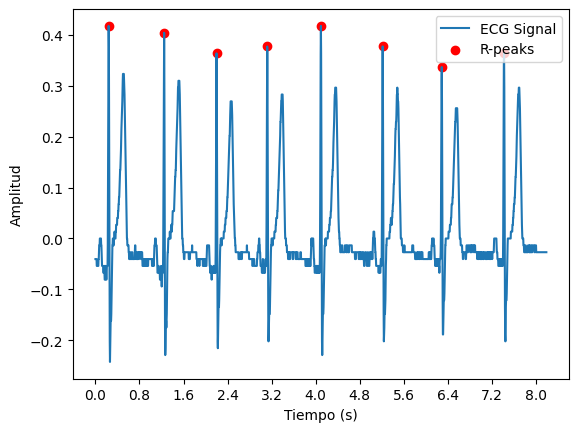

In [ ]:
#index = 3344
index = np.random.randint(len(X_train))
ecg_signal = X_train[index]
x=np.arange(0,2048,200)
t = np.arange(0,2049,1)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
#rpeaks = ecg.ecg(signal=ecg_signal[:,0], sampling_rate=250, show=False)['rpeaks']
rpeaks = ecg.engzee_segmenter(signal=ecg_signal[:,0], sampling_rate=250, threshold=0.48)
plt.plot(t, ecg_signal, label='ECG Signal')
plt.scatter(t[rpeaks], ecg_signal[rpeaks], color='red', label='R-peaks')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

In [ ]:
np.arange(0,2048,200).shape


(11,)

Text(0, 0.5, 'ECG signal')

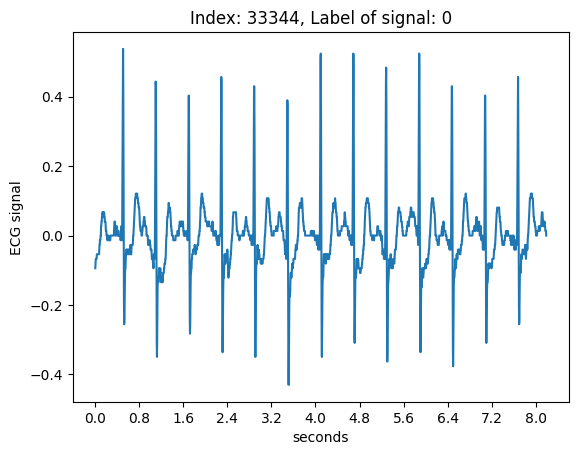

In [ ]:

#index = np.random.randint(len(X_train))
index = 33344
x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_train[index])
plt.title('Index: %i, Label of signal: %i'  % (index, np.argmax(y_train[index])))
plt.xlabel('seconds')
plt.ylabel('ECG signal')

##### Modelo

In [ ]:
# Definir la función de Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_sum(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return focal_loss_func

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Definir el modelo
model = Sequential()

# Capa LSTM con 64 unidades
model.add(LSTM(64, input_shape=(1750, 1)))

# Capa totalmente conectada (Dense) con 32 unidades y activación 'relu'
model.add(Dense(32, activation='relu'))

# Capa totalmente conectada (Dense) con 3 unidades y activación 'softmax' para clasificación multiclase
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 19075 (74.51 KB)
Trainable params: 19075 (74.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(np.squeeze(X_train2, axis=-1), y_train, epochs=2, batch_size=32, validation_split=0.2)

Epoch 1/2
2340/2340 [==============================] - 132s 54ms/step - loss: 3.4080 - accuracy: 0.5651 - val_loss: 3.3946 - val_accuracy: 0.5643
Epoch 2/2
2340/2340 [==============================] - 132s 57ms/step - loss: 3.3897 - accuracy: 0.5681 - val_loss: 3.4227 - val_accuracy: 0.5627


In [ ]:
y_pred = model.predict(X_test2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

731/731 [==============================] - 22s 29ms/step
Matriz de Confusión:
[[12413     0   611]
 [  887     0    45]
 [ 8639     0   796]]


Ta pocho

In [ ]:
np.bincount(y_true_classes)

array([13024,   932,  9435])

#### Version 1: Data augmentation

##### Preprocessamiento

In [ ]:
bin_counts = np.bincount(np.argmax(y_train,axis=1))
assert bin_counts[1] == 41775, "First create syntetic data "

In [ ]:
!pip install biosppy
from biosppy.signals import ecg
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(np.squeeze(X_train))
X_test = scaler.transform(np.squeeze(X_test))
X_val = scaler.transform(np.squeeze(X_val))

X_train.shape
##OJO
# Esto no esta funcionando por que no estan dnado resultados del mismo tamaño.


(125325, 2049)

##### Modelo

In [ ]:
# Definir la función de Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_func(y_true, y_pred):
        epsilon = 1e-8
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_sum(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return focal_loss_func

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Definir el modelo
model = Sequential()

# Capa LSTM con 64 unidades
model.add(LSTM(64, input_shape=(2049, 1)))

# Capa totalmente conectada (Dense) con 32 unidades y activación 'relu'
model.add(Dense(32, activation='relu'))

# Capa totalmente conectada (Dense) con 3 unidades y activación 'softmax' para clasificación multiclase
model.add(Dense(3, activation='softmax'))

# Compilar el modelo
model.compile(optimizer='adam', loss="categorical_focal_crossentropy", metrics=['accuracy'])

# Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 19075 (74.51 KB)
Trainable params: 19075 (74.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks = [EarlyStopping])

Epoch 1/10
3917/3917 [==============================] - 266s 67ms/step - loss: 0.1160 - accuracy: 0.4328 - val_loss: 0.1144 - val_accuracy: 0.3192
Epoch 2/10
3014/3917 [======================>.......] - ETA: 58s - loss: 0.1162 - accuracy: 0.4280

KeyboardInterrupt: ignored

731/731 [==============================] - 22s 29ms/step
Matriz de Confusión:
[[12413     0   611]
 [  887     0    45]
 [ 8639     0   796]]


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

731/731 [==============================] - 27s 35ms/step


In [ ]:
# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

Clase Normal - Precision: 0.8511673151750972, Recall: 0.26873464373464373, F1-score: 0.4084967320261438, Support: 13024
Clase Arrhythmia - Precision: 0.06516211061665607, Recall: 0.21995708154506438, F1-score: 0.10053948013732222, Support: 932
Clase Noise - Precision: 0.5145974090373768, Recall: 0.879915209326974, F1-score: 0.6494055068836045, Support: 9435
Matriz de Confusión:
[[3500 2245 7279]
 [ 175  205  552]
 [ 437  696 8302]]


Ta pocho

In [ ]:
np.bincount(y_true_classes)

array([13024,   932,  9435])

### A 1D Convolutional Neural Network for Heartbeat Classification from Single Lead ECG (Xiaolin, Cardiff & John, 2020)

#### Versión 1: Data aumentation only

##### Arquitectura

In [ ]:
def build_model():
  np.random.seed(1)
  random.seed(1)
  tf.random.set_seed(1)
  input=keras.Input(shape=(2049, 1))
  x = layers.Conv1D(128, 50, 3, activation='relu')(input)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(2, 3)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv1D(32, 7, 1, activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPooling1D(2, 2)(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Conv1D(32, 9, 1, activation='relu')(x)
  x = layers.Flatten()(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(128, activation='softmax')(x)
  output = layers.Dense(3,activation='softmax')(x)
  model = keras.Model(inputs=input, outputs=output)
  model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
history=model.fit(X_train_res,y_train_res,batch_size=128,epochs=100,validation_data=(X_val, y_val),verbose=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2049, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 667, 128)          6528      
                                                                 
 batch_normalization (Batch  (None, 667, 128)          512       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 222, 128)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 222, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 32)           28704 

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calcular metricas
# Calcular precision, recall, f1-score y support para cada clase
precision, recall, f1, support = precision_recall_fscore_support(y_true_classes, y_pred_classes)

# Imprimir las métricas para cada clase
for i in range(len(precision)):
    print(f"Clase {dict_class[i]} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1[i]}, Support: {support[i]}")
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

print("Matriz de Confusión:")
print(conf_matrix)

731/731 [==============================] - 2s 3ms/step
Clase Normal - Precision: 0.9439200880918672, Recall: 0.9214527027027027, F1-score: 0.9325510917709223, Support: 13024
Clase Arrhythmia - Precision: 0.7810707456978967, Recall: 0.8766094420600858, F1-score: 0.826086956521739, Support: 932
Clase Noise - Precision: 0.8949226456235074, Recall: 0.9135135135135135, F1-score: 0.9041225217664953, Support: 9435
Matriz de Confusión:
[[12001    67   956]
 [   59   817    56]
 [  654   162  8619]]


In [ ]:
model.save(data_path + '/models/1D_CNN_MODEL_bal_train.keras')

NameError: ignored

### Basic Preprocessing Probe

In [ ]:
# Filtro gaussiano
from scipy.ndimage import gaussian_filter1d
sigma = 1.0
X_train_filtered = np.array([gaussian_filter1d(signal, sigma=sigma) for signal in X_train])
#Z-Score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_filtered = scaler.fit_transform(np.squeeze(X_train_filtered))


(2049, 1)


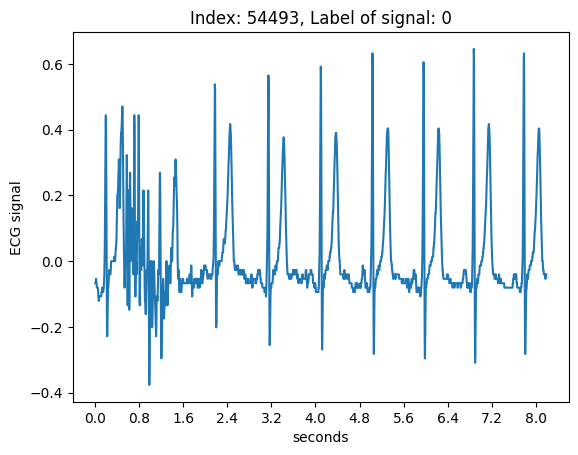

In [ ]:
#Mostrar señal original
index = np.random.randint(len(X_train))
x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_train[index])
plt.title('Index: %i, Label of signal: %i'  % (index, np.argmax(y_train[index])))
plt.xlabel('seconds')
plt.ylabel('ECG signal')

plt.show()

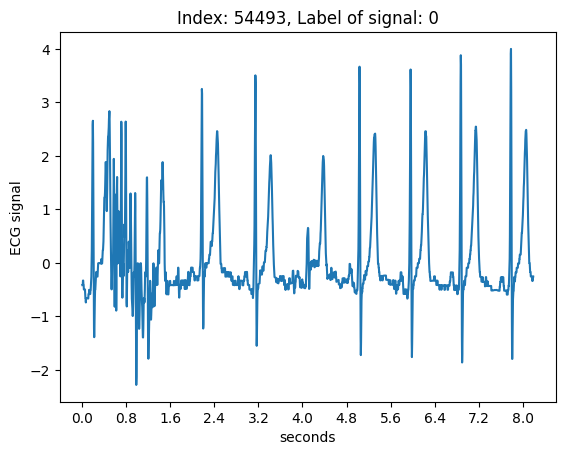

In [ ]:
x=np.arange(0,2048,200)
xi = x/250 # sample rate of recording: 250Hz
plt.xticks(x,xi)
plt.plot(X_train_filtered[index])
plt.title('Index: %i, Label of signal: %i'  % (index, np.argmax(y_train[index])))
plt.xlabel('seconds')
plt.ylabel('ECG signal')

plt.show()

### End-to-End Trainable Gaussian Filtering for Electrocardiogram Signal Classification Using Deep Learning (Nalmpantis et al, 2023)

In [ ]:
# Importar capa basada en pytorch
os.chdir(data_path + '/capa_filtro')
from deep_gaussian_filtering import DeepGaussianFilter

In [ ]:
pip install onnx onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.0 MB/s eta 0:00:00


In [ ]:
import torch
# Crea la capa de PyTorch
layer = DeepGaussianFilter()
xd = torch.randn((1,2049))
print(xd)
# Convierte la capa a un modelo ONNX
torch.onnx.export(layer, xd, "deep_gaussian_filter.onnx", verbose=True)

tensor([[-0.2797, -0.3543, -0.6207,  ..., -0.8632,  0.6707,  0.0369]])


In [ ]:
pip install --upgrade onnx2keras

  Preparing metadata (setup.py) ... done
  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24577 sha256=bae2268c3104a17f2a1ec0e6f3bf53f040c80d6e39e4f32172f1fd650e4d4fa0
  Stored in directory: /root/.cache/pip/wheels/a1/fb/c9/349c27912022d104c7dd5f5d272595c33b1b959c4468d5e784
Successfully built onnx2keras


In [ ]:
#Pasar de ONNX a Keras
import onnx
import onnx2keras
from onnx2keras import onnx_to_keras
onnx_model = onnx.load("deep_gaussian_filter.onnx")
print(onnx_model)
input_all = [node.name for node in onnx_model.graph.input]
deep_gaussian_filter = onnx_to_keras(onnx_model, ['onnx::Unsqueeze_0'])


ir_version: 8
producer_name: "pytorch"
producer_version: "2.1.0"
graph {
  node {
    output: "/Constant_output_0"
    name: "/Constant"
    op_type: "Constant"
    attribute {
      name: "value"
      t {
        dims: 1
        data_type: 7
        raw_data: "\001\000\000\000\000\000\000\000"
      }
      type: TENSOR
    }
    doc_string: "/content/gdrive/MyDrive/Deep_learning/Deep_Project/capa_filtro/deep_gaussian_filtering.py(72): forward\n/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py(1508): _slow_forward\n/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py(1527): _call_impl\n/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py(1518): _wrapped_call_impl\n/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py(124): wrapper\n/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py(133): forward\n/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py(1527): _call_impl\n/usr/local/lib/python3.10/dist-packages/torc

AttributeError: ignored